In [6]:
# use this shell command to upload tensorboard results to tensorboard dev
'''
tensorboard dev upload \
  --logdir resized_logs \
  --name "Results" \
  --description "Different runs" \
  --one_shot
'''

'\ntensorboard dev upload   --logdir resized_logs   --name "Results"   --description "Different runs"   --one_shot\n'

In [1]:
from packaging import version

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import tensorboard as tb
import tensorflow as tf

from gym_duckietown.envs import DuckietownEnv
from gym_duckietown.simulator import Simulator

from project_utils import PositionObservation, DtRewardWrapper, DiscreteActionWrapper, DiscreteActionWrapperTrain, NoiseWrapper

from DDQN import DDQN
from DQN import DQN

In [2]:
# tensorflow gpu memory management
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
# check if it is possible to use tensorboard dataframe support
major_ver, minor_ver, _ = version.parse(tb.__version__).release
assert major_ver >= 2 and minor_ver >= 3, \
    "This notebook requires TensorBoard 2.3 or later."
print("TensorBoard version: ", tb.__version__)

TensorBoard version:  2.3.0


In [4]:
# set to True when testing cnn
testing_cnn = False
# number of trained models
N_TRIALS = 10
# to retrieve data from files and not perform tests once again set to True
retrieve_from_files = True

In [11]:
# for each of the 10 models perform some tests of lane following 
if not retrieve_from_files:
    # environment used to compute lane following metrics
    env = DuckietownEnv(
        seed=123, # random seed
        map_name='zigzag_noobj',
        max_steps=2000, # 2000 steps max
        domain_rand=0,
        accept_start_angle_deg=4, # start close to straight
        full_transparency=True,
        distortion=False,
        graphics=testing_cnn,
    )

    env = NoiseWrapper(env)
    env = DiscreteActionWrapper(env)   # we use a different action wrapper from training since we can now stay still also
    if testing_cnn:
        env = ResizeWrapper(env)
    else:
        env = PositionObservation(env)
    env = DtRewardWrapper(env)

    episodes_number = 10
    lane_follower_performance = dict({'travel_distance':[], 'survival_time':[], 'lateral_deviation':[], 'major_infractions':[]})
    for trial in range(1, N_TRIALS+1):
        if testing_cnn:
            weights_name = 'weights/ddqn_duckietown_cnn_weightsModel_' + str(trial) + '.h5'
        else:
            weights_name = 'weights/ddqn_duckietown_weightsModel_' + str(trial) + '.h5'
        model = DDQN(env, activation='relu', cnn=testing_cnn, mlp_width=64)
        model.load(weights_name)
        obs = env.reset()
        trial_travel_dist, trial_survival_time, trial_lateral_deviation, trial_major_infractions = [], [], [], []
        for i in range(1,episodes_number+1):
            obs = env.reset()
            ep_travel_dist = 0
            ep_survival_time = 0
            ep_lateral_deviation = []
            ep_major_infractions = 0
            old_tile = [-100, -100]
            done = False
            while not done:
                action, q_value = model.predict(obs)
                obs, reward, done, info = env.step(action)
                # computing travel distance -- adding 1 if tile changes
                curr_tile = info['Simulator']['tile_coords']
                if old_tile != curr_tile:
                    ep_travel_dist += 1
                    old_tile = curr_tile
                # adding 1 to the survival time
                ep_survival_time += 1
                # adding distances to an array used to compute lateral deviation (absolute value)
                ep_lateral_deviation.append(abs(info['Simulator']['lane_position']['dist'])) 
                # if reward is less or equal to 10 then it isn't correctly driving in the right lane
                if reward < 10:
                    ep_major_infractions += 1
                # print
                print(f"Trial {trial:5} \t Episode {i:5} \t Step {ep_survival_time:04d}", end='\r')
            # mean of all distances is lateral deviation
            ep_lateral_deviation = np.mean(ep_lateral_deviation)
            trial_travel_dist.append(ep_travel_dist)
            trial_survival_time.append(ep_survival_time)
            trial_lateral_deviation.append(ep_lateral_deviation)
            trial_major_infractions.append(ep_major_infractions)
        # medians -- we have 10 * 4 values in the dictionary
        lane_follower_performance['travel_distance'].append(np.median(trial_travel_dist))
        lane_follower_performance['survival_time'].append(np.median(trial_survival_time))
        lane_follower_performance['lateral_deviation'].append(np.median(trial_lateral_deviation))
        lane_follower_performance['major_infractions'].append(np.median(trial_major_infractions))

    # converting to pandas dataframe
    lane_follower_dataframe = pd.DataFrame.from_dict(lane_follower_performance)
    # saving to csv
    if testing_cnn:
        csv_path = 'lane_follower_data_cnn.csv'
    else:
        csv_path = 'lane_follower_data.csv'
    lane_follower_dataframe.to_csv(csv_path, index=False)
    lane_follower_dataframe_roundtrip = pd.read_csv(csv_path)
    pd.testing.assert_frame_equal(lane_follower_dataframe_roundtrip, lane_follower_dataframe)

In [15]:
# retrieve data from file
if retrieve_from_files:
    if testing_cnn:
        csv_path = 'lane_follower_data_cnn.csv'
    else:
        csv_path = 'lane_follower_data.csv'
    lane_follower_dataframe = pd.read_csv(csv_path) 

In [16]:
lane_follower_dataframe

,travel_distance,survival_time,lateral_deviation,major_infractions
0,50.5,2000.0,0.029731,583.0
1,62.5,2000.0,0.035125,568.0
2,52.5,2000.0,0.027150,461.5
3,47.5,2000.0,0.027086,476.0
4,46.0,2000.0,0.034123,522.5
5,61.5,2000.0,0.033525,442.5
6,63.0,2000.0,0.041059,696.5
7,47.5,2000.0,0.022498,329.0
8,52.0,2000.0,0.027146,473.0
9,38.0,2000.0,0.022718,345.5


In [44]:
# showing  data along with mean and standard deviation
print(lane_follower_dataframe)
print("\nmean")
print(lane_follower_dataframe.mean())
print("\nstandard deviation")
print(lane_follower_dataframe.std())

   travel_distance  survival_time  lateral_deviation  major_infractions
0             50.5         2000.0           0.029731              583.0
1             62.5         2000.0           0.035125              568.0
2             52.5         2000.0           0.027150              461.5
3             47.5         2000.0           0.027086              476.0
4             46.0         2000.0           0.034123              522.5
5             61.5         2000.0           0.033525              442.5
6             63.0         2000.0           0.041059              696.5
7             47.5         2000.0           0.022498              329.0
8             52.0         2000.0           0.027146              473.0
9             38.0         2000.0           0.022718              345.5

mean
travel_distance        52.100000
survival_time        2000.000000
lateral_deviation       0.030016
major_infractions     489.750000
dtype: float64

standard deviation
travel_distance        8.140434
sur

In [11]:
# for each of the 10 models perform some tests look at mean q values and look at mean reward then see if converges
# do one test with dqn to see if that one doesn't converge

if not retrieve_from_files:
    # environment used to compute maximum cumulative rewards with best learned policy
    env = DuckietownEnv(
        seed=123, # random seed
        map_name='loop_empty',
        max_steps=2000, # 2000 steps max
        domain_rand=0,
        accept_start_angle_deg=4, # start close to straight
        full_transparency=True,
        distortion=False,
        graphics=testing_cnn,
    )
    
    env = NoiseWrapper(env)
    env = DiscreteActionWrapper(env)   # we use a different action wrapper from training since we can now stay still also
    if testing_cnn:
        env = ResizeWrapper(env)
    else:
        env = PositionObservation(env)
    env = DtRewardWrapper(env)
    
    obs = env.reset()
    
    discount_rate = 0.99
    
    episodes_number = 10
    
    cdr_best_policy = []
    for trial in range(1, N_TRIALS+1):
        obs = env.reset()
        if testing_cnn:
            weights_name = 'weights/ddqn_duckietown_cnn_weightsModel_' + str(trial) + '.h5'
        else:
            weights_name = 'weights/ddqn_duckietown_weightsModel_' + str(trial) + '.h5'
        model = DDQN(env, activation='relu', cnn=testing_cnn, mlp_width=64)
        model.load(weights_name)
        cdr_best_policy_trial = []
        for i in range(1,episodes_number+1):
            obs = env.reset()
            step = 0
            cdr = 0
            done = False
            while not done:
                action, q_value = model.predict(obs)
                obs, reward, done, info = env.step(action)
                cdr += (discount_rate ** step)* reward
                step += 1
                print(f"Trial {trial:5} \t Episode {i:5} \t Step {step:04d} \t CDR {cdr:08.2f}", end='\r')
            cdr_best_policy_trial.append(cdr)
        cdr_best_policy.append(np.mean(cdr_best_policy_trial))
    print("\n")
    
    # save CDRs
    if testing_cnn:
        path = 'CDR_cnn.txt' 
    else:
        path = 'CDR.txt'
    file_obj = open(path,"w+")
    for i in range(len(cdr_best_policy)):
         file_obj.write(f"Model {i+1} CDR {cdr_best_policy[i]}\n")
    file_obj.close()

/home/marco/anaconda3/envs/gym-duckietown-tf2/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Trial    10 	 Episode    10 	 Step 2000 	 CDR 00913.87



In [15]:
# DQN CDR

if not retrieve_from_files:
    # environment used to compute maximum cumulative rewards with best learned policy
    env = DuckietownEnv(
        seed=123, # random seed
        map_name='loop_empty',
        max_steps=2000, # 2000 steps max
        domain_rand=0,
        accept_start_angle_deg=4, # start close to straight
        full_transparency=True,
        distortion=False,
        graphics=testing_cnn,
    )
    
    env = NoiseWrapper(env)
    env = DiscreteActionWrapper(env)   # we use a different action wrapper from training since we can now stay still also
    if testing_cnn:
        env = ResizeWrapper(env)
    else:
        env = PositionObservation(env)
    env = DtRewardWrapper(env)
    
    obs = env.reset()
    
    discount_rate = 0.99
    
    episodes_number = 10
    
    cdr_dqn = []
    obs = env.reset()
    if testing_cnn:
        weights_name = 'weights/dqn_duckietown_cnn_weightsModel_' + str(trial) + '.h5'
    else:
        weights_name = 'weights/dqn_duckietown_weightsDQNModel_1.h5'
    model = DQN(env, activation='relu', cnn=testing_cnn, mlp_width=64)    
    model.load(weights_name)
    for i in range(1,episodes_number+1):
        obs = env.reset()
        step = 0
        cdr = 0
        done = False
        while not done:
            action, q_value = model.predict(obs)
            obs, reward, done, info = env.step(action)
            cdr += (discount_rate ** step)* reward
            step += 1
            print(f"Trial {1:5} \t Episode {i:5} \t Step {step:04d} \t CDR {cdr:08.2f}", end='\r')
        cdr_dqn.append(cdr)
    cdr_dqn = np.mean(cdr_dqn)
    print("\n")
    
    # save CDRs
    if testing_cnn:
        path = 'DQN_CDR_cnn.txt' 
    else:
        path = 'DQN_CDR.txt'
    file_obj = open(path,"w+")
    file_obj.write(f"DQN Model 1 CDR {cdr_dqn}\n")
    file_obj.close()

/home/marco/anaconda3/envs/gym-duckietown-tf2/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Trial     1 	 Episode    10 	 Step 2000 	 CDR 00844.34



In [12]:
# load CDRs from file
if retrieve_from_files:
    # retrieve DDQNs CDRs
    cdr_best_policy = []
    if testing_cnn:
        path = 'CDR_cnn.txt' 
    else:
        path = 'CDR.txt'
    file_obj = open(path,"r")
    for line in file_obj:
        if len(line.split())>0:
            cdr_best_policy.append(float(line.split()[-1]))
    file_obj.close()
    # retrieve DQN CDR
    if testing_cnn:
        path = 'DQN_CDR_cnn.txt' 
    else:
        path = 'DQN_CDR.txt'
    file_obj = open(path,"r")
    for line in file_obj:
        if len(line.split())>0:
            cdr_dqn = float(line.split()[-1])
    file_obj.close()

In [13]:
# max theoric cumulative discounted reward
MAX_STRAIGHT_VEL = 0.84    # 0.6 vel ----> 0.84 speed
discount_rate = 0.99
max_cumulative_discounted_reward = 0
for i in range(2000):
    max_cumulative_discounted_reward += (discount_rate ** i)*(10+MAX_STRAIGHT_VEL)

In [14]:
print("Various CDRs: ", cdr_best_policy)
cdr_best_policy_mean = np.mean(cdr_best_policy)
print("Mean of CDRs: ", cdr_best_policy_mean)
max_trained_cdr = np.max(cdr_best_policy)
print("Max trained policy CDR: ", max_trained_cdr)
print("Max theoric cumulative discounted reward: ", max_cumulative_discounted_reward)
print("DQN CDR: ", cdr_dqn)

Various CDRs:  [664.5749729561443, 795.9963776373874, 743.6236736049468, 610.8625673102163, 728.9412989627142, 753.5367254306672, 642.3677518806087, 735.6316611699158, 854.3410416556965, 739.3060888902811]
Mean of CDRs:  726.9182159498578
Max trained policy CDR:  854.3410416556965
Max theoric cumulative discounted reward:  1083.9999979796917
DQN CDR:  628.9539058112481


In [15]:
# tutorial on https://www.tensorflow.org/tensorboard/dataframe_api
# once data is uploaded to tensorboard dev extract it
# check the experiment id in the URL
# full tensorboard dev experiment https://tensorboard.dev/experiment/pe1cGjvxTqOrKHBSwZBQTQ/
# resized experiment: https://tensorboard.dev/experiment/LxDMGZTqRyigXGewOSLzjQ/
experiment_id = "LxDMGZTqRyigXGewOSLzjQ"
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
df = experiment.get_scalars()
df

,run,tag,step,value
0,ddqn_duckietown_Model_1,average_reward_per_500steps,1,3.111027
1,ddqn_duckietown_Model_1,average_reward_per_500steps,2,2.761927
2,ddqn_duckietown_Model_1,average_reward_per_500steps,3,3.440435
3,ddqn_duckietown_Model_1,average_reward_per_500steps,4,5.119313
4,ddqn_duckietown_Model_1,average_reward_per_500steps,5,2.202207
...,...,...,...,...
45915,dqn_duckietown_DQN_NoTarget_Model_1,steps_per_episode,2292,504.000000
45916,dqn_duckietown_DQN_NoTarget_Model_1,steps_per_episode,2293,88.000000
45917,dqn_duckietown_DQN_NoTarget_Model_1,steps_per_episode,2294,503.000000
45918,dqn_duckietown_DQN_NoTarget_Model_1,steps_per_episode,2295,102.000000


In [8]:
# saving dataframe to csv
if testing_cnn:
    csv_path = 'models_data_cnn.csv'
else:
    csv_path = 'models_data.csv'
df.to_csv(csv_path, index=False)
df_roundtrip = pd.read_csv(csv_path)
pd.testing.assert_frame_equal(df_roundtrip, df)

In [9]:
# mean and standard deviation of average and cumulative reward per 500 steps and episode
avg_steps_reward_results = df.query('tag == "average_reward_per_500steps" \
                                        and run != "dqn_duckietown_DQN_NoTarget_Model_1" \
                                        and run != "dqn_duckietown_DQNModel_1"')
cumul_steps_reward_results = df.query('tag == "cumulative_reward_per_500steps" \
                                        and run != "dqn_duckietown_DQN_NoTarget_Model_1" \
                                        and run != "dqn_duckietown_DQNModel_1"')
avg_ep_reward_results = df.query('tag == "average_reward_per_episode" \
                                        and run != "dqn_duckietown_DQN_NoTarget_Model_1" \
                                        and run != "dqn_duckietown_DQNModel_1"')
cumul_ep_reward_results = df.query('tag == "cumulative_reward_per_episode" \
                                        and run != "dqn_duckietown_DQN_NoTarget_Model_1" \
                                        and run != "dqn_duckietown_DQNModel_1"')

In [10]:
max_reward = 10+MAX_STRAIGHT_VEL

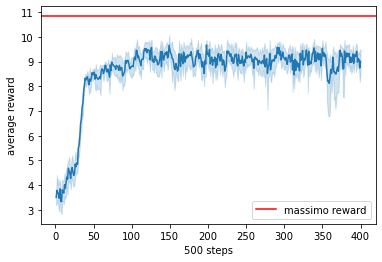

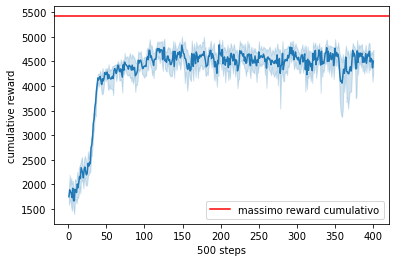

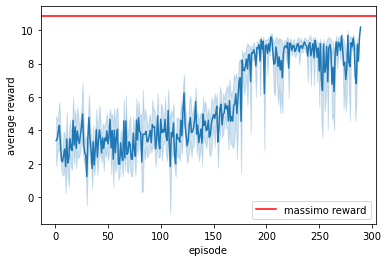

In [17]:
# average reward per 500 steps
plt.figure()
sns.lineplot(data=avg_steps_reward_results, x="step", y="value") #.set_title("average reward per 500 steps")
plt.axhline(max_reward, color='red', label='massimo reward')
plt.xlabel("500 steps")
plt.ylabel("average reward")
plt.legend(loc='lower right')

# cumulative reward per 500 steps
plt.figure()
sns.lineplot(data=cumul_steps_reward_results, x="step", y="value") #.set_title("cumulative reward per 500 steps")
plt.axhline(max_reward*500, color='red', label='massimo reward cumulativo')
plt.xlabel("500 steps")
plt.ylabel("cumulative reward")
plt.legend(loc='lower right')

# average reward per episode
plt.figure()
sns.lineplot(data=avg_ep_reward_results, x="step", y="value") #.set_title("average reward per episode")
plt.axhline(max_reward, color='red', label='massimo reward')
plt.xlabel("episode")
plt.ylabel("average reward")
plt.legend(loc='lower right')

In [18]:
# calcolo del massimo reward cumulativo possibile per episodi con diverso numero di step
lista = []
test = df.query('tag == "steps_per_episode"\
            and run != "dqn_duckietown_DQN_NoTarget_Model_1" \
            and run != "dqn_duckietown_DQNModel_1"')
test = test.loc[:,['run','value']]
for run_name in test.run.unique():
    a = test[test.run == run_name]
    a = a['value'].tolist()
    lista.append(a)
length = max(map(len, lista))
#y=np.array([xi+[np.mean(xi)]*(length-len(xi)) for xi in lista])
y = np.array([xi+[max(xi)]*(length-len(xi)) for xi in lista])
#massimo_poss = np.mean(y, axis=0)
massimo_poss = np.max(y, axis=0)
max_cumul_rew = massimo_poss * max_reward

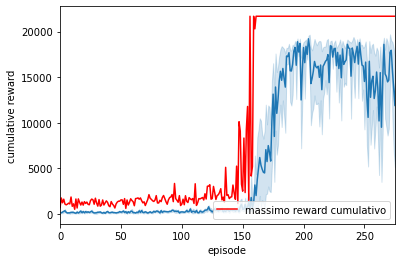

In [29]:
# cumulative reward per episode
plt.figure()
if testing_cnn:
    sns.lineplot(data=cumul_ep_reward_results, x="step", y="value") #.set_title("cumulative reward per episode")
else:
    # da tagliare a x=260 (comunque prima dell'outlier)
    # curva del "massimo possibile" moltiplicando steps per episode per max_reward
    sns.lineplot(data=cumul_ep_reward_results, x="step", y="value") #.set_title("cumulative reward per episode")
    sns.lineplot(data=max_cumul_rew, color='red', label='massimo reward cumulativo')
    plt.xlim(0,275)
plt.xlabel("episode")
plt.ylabel("cumulative reward")
plt.legend(loc='lower right')

In [16]:
# mean q values (with DQN and DQN no target comparison, line of best CDR and max thorical CDR)
# solo DDQN
mean_steps_q_values = df.query('tag == "mean_q_values_per_500steps" \
                                and run != "dqn_duckietown_DQN_NoTarget_Model_1" \
                                and run != "dqn_duckietown_DQNModel_1"')
mean_ep_q_values = df.query('tag == "mean_q_values_per_episode" \
                                and run != "dqn_duckietown_DQN_NoTarget_Model_1" \
                                and run != "dqn_duckietown_DQNModel_1"')
# DQN (con target network)
mean_steps_q_values_dqn = df.query('tag == "mean_q_values_per_500steps" \
                                            and run == "dqn_duckietown_DQNModel_1"')
mean_ep_q_values_dqn = df.query('tag == "mean_q_values_per_episode" \
                                            and run == "dqn_duckietown_DQNModel_1"')
# DQN (SENZA TARGET NETWORK)
mean_steps_q_values_dqn_notar = df.query('tag == "mean_q_values_per_500steps" \
                                and run == "dqn_duckietown_DQN_NoTarget_Model_1"')
mean_ep_q_values_dqn_notar = df.query('tag == "mean_q_values_per_episode" \
                                and run == "dqn_duckietown_DQN_NoTarget_Model_1"')

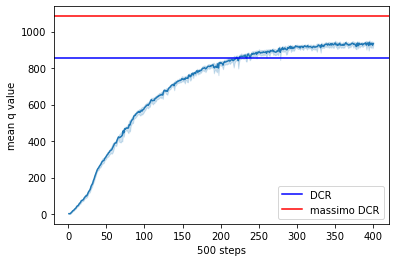

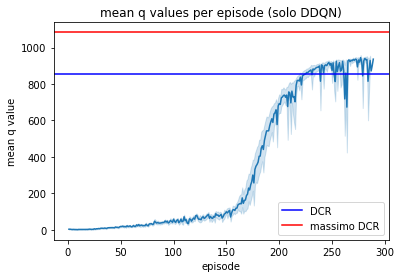

In [29]:
# mean q values DDQN
# per 500 steps
plt.figure()
sns.lineplot(data=mean_steps_q_values, x="step", y="value") #.set_title("mean q values per 500 steps (solo DDQN)")
plt.axhline(max_trained_cdr, color='blue', label='DCR')
plt.axhline(max_cumulative_discounted_reward, color='red', label='massimo DCR')
plt.xlabel("500 steps")
plt.ylabel("mean q value")
plt.legend(loc='lower right')

# per episode
plt.figure()
sns.lineplot(data=mean_ep_q_values, x="step", y="value").set_title("mean q values per episode (solo DDQN)")
plt.axhline(max_trained_cdr, color='blue', label='DCR')
plt.axhline(max_cumulative_discounted_reward, color='red', label='massimo DCR')
plt.xlabel("episode")
plt.ylabel("mean q value")
plt.legend(loc='lower right')

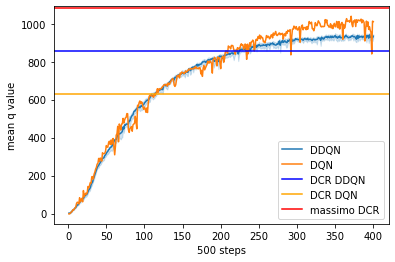

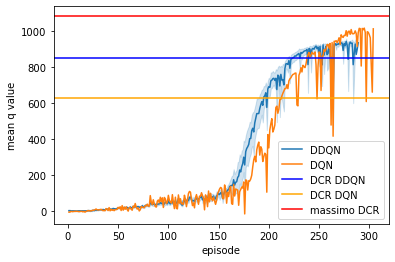

In [28]:
# mean q values DDQN + DQN (con target network)
# per 500 steps
plt.figure()
sns.lineplot(data=mean_steps_q_values, x="step", y="value", label="DDQN") #.set_title("mean q values per 500 steps (DDQN & DQN con target network)")
sns.lineplot(data=mean_steps_q_values_dqn, x="step", y="value", label="DQN")
plt.axhline(max_trained_cdr, color='blue', label='DCR DDQN')
plt.axhline(cdr_dqn, color='orange', label='DCR DQN')
plt.axhline(max_cumulative_discounted_reward, color='red', label='massimo DCR')
plt.xlabel("500 steps")
plt.ylabel("mean q value")
plt.legend(loc='lower right')

# per episode
plt.figure()
sns.lineplot(data=mean_ep_q_values, x="step", y="value", label="DDQN") #.set_title("mean q values per episode (DDQN & DQN con target network)")
sns.lineplot(data=mean_ep_q_values_dqn, x="step", y="value", label="DQN")
plt.axhline(max_trained_cdr, color='blue', label='DCR DDQN')
plt.axhline(cdr_dqn, color='orange', label='DCR DQN')
plt.axhline(max_cumulative_discounted_reward, color='red', label='massimo DCR')
plt.xlabel("episode")
plt.ylabel("mean q value")
plt.legend(loc='lower right')

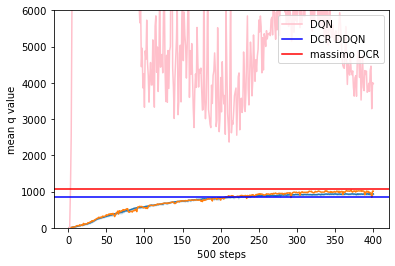

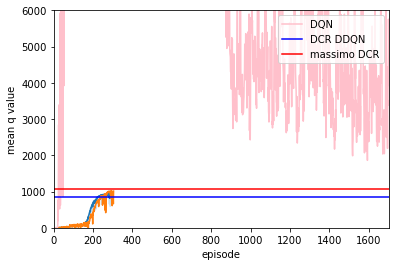

In [17]:
# mean q values DDQN + DQN (senza target network)
# per 500 steps
plt.figure()
sns.lineplot(data=mean_steps_q_values, x="step", y="value") #.set_title("mean q values per 500 steps (DDQN & DQN senza target network)")
sns.lineplot(data=mean_steps_q_values_dqn, x="step", y="value")
sns.lineplot(data=mean_steps_q_values_dqn_notar, x="step", y="value", color='pink', label="DQN")
plt.ylim(0,6000)
plt.axhline(max_trained_cdr, color='blue', label='DCR DDQN')
plt.axhline(max_cumulative_discounted_reward, color='red', label='massimo DCR')
plt.xlabel("500 steps")
plt.ylabel("mean q value")
plt.legend(loc='upper right')

# per episode
plt.figure()
sns.lineplot(data=mean_ep_q_values, x="step", y="value") #.set_title("mean q values per episode (DDQN & DQN senza target network)")
sns.lineplot(data=mean_ep_q_values_dqn, x="step", y="value")
sns.lineplot(data=mean_ep_q_values_dqn_notar, x="step", y="value", color='pink', label="DQN")
plt.xlim(0,1700)
plt.ylim(0,6000)
plt.axhline(max_trained_cdr, color='blue', label='DCR DDQN')
plt.axhline(max_cumulative_discounted_reward, color='red', label='massimo DCR')
plt.xlabel("episode")
plt.ylabel("mean q value")
plt.legend(loc='upper right')

In [24]:
# steps per episode
steps_per_ep = df.query('tag == "steps_per_episode" \
                            and run != "dqn_duckietown_DQN_NoTarget_Model_1" \
                            and run != "dqn_duckietown_DQNModel_1"')

Text(0, 0.5, 'steps')

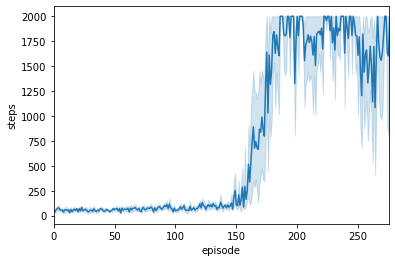

In [25]:
# plot steps per episode
plt.figure()
if testing_cnn:
    sns.lineplot(data=cumul_ep_reward_results, x="step", y="value") #.set_title("cumulative reward per episode")
else:
    # da tagliare a x=260 (comunque prima dell'outlier)
    sns.lineplot(data=steps_per_ep, x="step", y="value") #.set_title("steps per episode")
    plt.xlim(0,275)
plt.xlabel("episode")
plt.ylabel("steps")

In [26]:
# loss
loss_per_steps = df.query('tag == "avg_loss_per_500steps" \
                            and run != "dqn_duckietown_DQN_NoTarget_Model_1" \
                            and run != "dqn_duckietown_DQNModel_1"')
loss_per_ep = df.query('tag == "avg_loss_per_episode" \
                            and run != "dqn_duckietown_DQN_NoTarget_Model_1" \
                            and run != "dqn_duckietown_DQNModel_1"')

Text(0, 0.5, 'average loss')

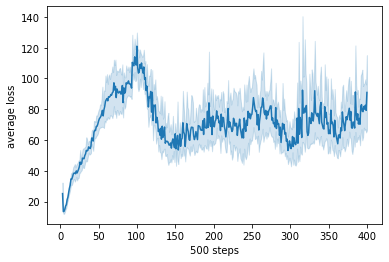

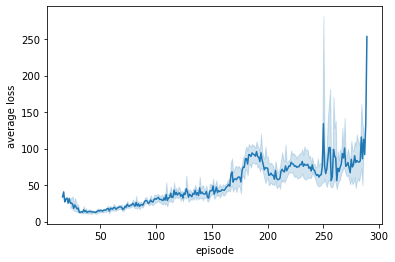

In [28]:
# plot loss
# per 500 steps
plt.figure()
sns.lineplot(data=loss_per_steps, x="step", y="value") #.set_title("average loss per 500 steps")
plt.xlabel("500 steps")
plt.ylabel("average loss")

# per episode
plt.figure()
sns.lineplot(data=loss_per_ep, x="step", y="value") #.set_title("average loss per episode")
plt.xlabel("episode")
plt.ylabel("average loss")